In [1]:
import matplotlib.pyplot as plt
import os, os.path
import glob
import pickle
import numpy as np
from numpy.polynomial import Polynomial
from scipy import ndimage, signal, interpolate
#import matplotlib
#matplotlib.use('PDF')
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014
from galpy.util import bovy_conversion, save_pickles, bovy_coords, bovy_plot
#import pal5_util_old as pal5_util
#from gd1_util import R0, V0
#import custom_stripping_df
import seaborn as sns
import astropy.units as u
from galpy import potential
%pylab inline
from matplotlib import cm, pyplot
from gd1_util_MWhaloshape import lb_to_phi12
from galpy.actionAngle import estimateBIsochrone, actionAngleIsochroneApprox



Populating the interactive namespace from numpy and matplotlib


In [2]:
#Jeremy and Jo's model, end of the leading arm
#NOTE: phi1 for this point gives -92 deg, this is a point along the orbit and not a point on the stream
ra=122.968652691887
dec=-9.969068202814725
d = 9.468134830338986
pmra= -1.0277792637560275
pmdec= -7.485334923475567
vlos = 303.54730262016966

lb=bovy_coords.radec_to_lb(np.radians(ra),np.radians(dec))
phi12=lb_to_phi12(lb[0],lb[1])

print (np.degrees(phi12[0])-360.,np.degrees(phi12[1]))

end_coord=[ra,dec,d,pmra,pmdec,vlos]

-92.10954738227082 -3.527698085246242


### determine the time at which the progenitor was at phi1 = -40 deg to get the phase space of the progenitor

In [3]:
tend=np.linspace(-0.031,-0.0316,20)  # these times were obtained by trial and error
diff=np.empty(len(tend))
for ii in range(len(tend)):
    obs= Orbit(end_coord,radec=True,ro=8.,vo=220.,solarmotion=[-11.1,24.,7.25])
    ts=np.linspace(0.,tend[ii],500)/bovy_conversion.time_in_Gyr(220.,8.)
    obs.integrate(ts,MWPotential2014)

    ra1=obs.ra(ts[-1])
    dec1=obs.dec(ts[-1])

    lb=bovy_coords.radec_to_lb(np.radians(ra1),np.radians(dec1))
    phi1=np.degrees(lb_to_phi12(lb[0],lb[1])[0])
    if phi1 > 180. : 
        phi1-=360.
    diff[ii]=np.abs(phi1-(-40.))
    
tpro=tend[argmin(diff)]
    
print (tpro)

-0.03153684210526316


### Integrate end coord to the progenitor's location

In [4]:
obs= Orbit(end_coord,radec=True,ro=8.,vo=220.,solarmotion=[-11.1,24.,7.25])
ts=np.linspace(0.,tpro,1000)/bovy_conversion.time_in_Gyr(220.,8.)
obs.integrate(ts,MWPotential2014)

ll=obs.ll(ts[-1])
bb=obs.bb(ts[-1])
dist=obs.dist(ts[-1])
pmll=obs.pmll(ts[-1])
pmbb=obs.pmbb(ts[-1])
vlos=obs.vlos(ts[-1])

gd1_prog_lb=[ll,bb,dist,pmll,pmbb,vlos]
print (gd1_prog_lb)

[188.04928416766532, 51.848594007807456, 7.559027173643999, 12.260258757214746, -5.140630283489461, 7.162732847549563]


### Find isochrone parameter

In [5]:
prog_orb=Orbit(gd1_prog_lb,lb=True,ro=8.,vo=220.,solarmotion=[-11.1,24.,7.25])
orb_galpy=prog_orb._orb.vxvv

ts1=np.linspace(0.,-3.4,1000)/bovy_conversion.time_in_Gyr(220.,8.)
prog_orb.integrate(ts1,MWPotential2014)

print (estimateBIsochrone(MWPotential2014,prog_orb.R(ts1)/8.,prog_orb.z(ts1))/8.)


[0.07302462 0.30884214 0.45459102]


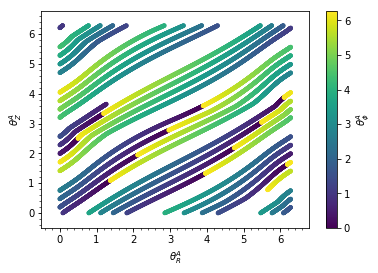

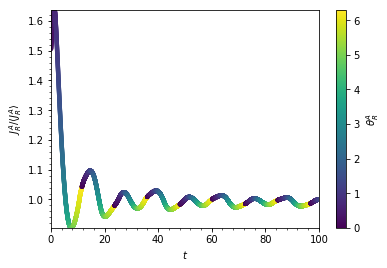

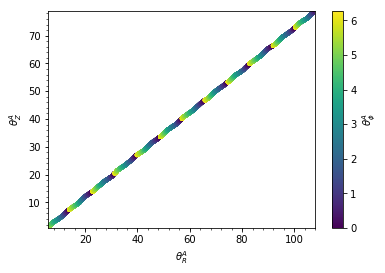

In [6]:
#Try different b following the above estimate and visually select based on linearity and quickness of convergence 

aAIA= actionAngleIsochroneApprox(pot=MWPotential2014,b=0.4)
aAIA(*orb_galpy)

aAIA.plot(*orb_galpy,type='araz')

aAIA.plot(*orb_galpy,type='jr')

aAIA.plot(*orb_galpy,type='araz',deperiod=True)

In [7]:
import gd1_util

#from above b=0.4 looks good

sdf_leading=gd1_util.setup_gd1model(age=3.4,new_orb_lb=gd1_prog_lb,isob=0.4)
sdf_trailing=gd1_util.setup_gd1model(leading=False,age=3.4,new_orb_lb=gd1_prog_lb,isob=0.4)


In [8]:
tracklb_trailing=np.radians(sdf_trailing._interpolatedObsTrackLB[:,0]),np.radians(sdf_trailing._interpolatedObsTrackLB[:,1])
tracklb_leading=np.radians(sdf_leading._interpolatedObsTrackLB[:,0]),np.radians(sdf_leading._interpolatedObsTrackLB[:,1])

phi12_trail=np.degrees(lb_to_phi12(tracklb_trailing[0],tracklb_trailing[1]))
phi12_lead=np.degrees(lb_to_phi12(tracklb_leading[0],tracklb_leading[1]))

#print (np.degrees(phi12[0])-360.,np.degrees(phi12[1]))
for ii in range(len(phi12_trail)):
    if phi12_trail[:,0][ii]>180.:
        phi12_trail[:,0][ii]-=360.
        
for ii in range(len(phi12_lead)):
    if phi12_lead[:,0][ii]>180.:
        phi12_lead[:,0][ii]-=360.

print (phi12_lead)
                          

[[ -39.65163566   -0.26132857]
 [ -39.83236742   -0.26105436]
 [ -40.01314565   -0.26083776]
 ...
 [-139.18873685  -10.79668767]
 [-139.23142714  -10.80901461]
 [-139.27407696  -10.82133977]]


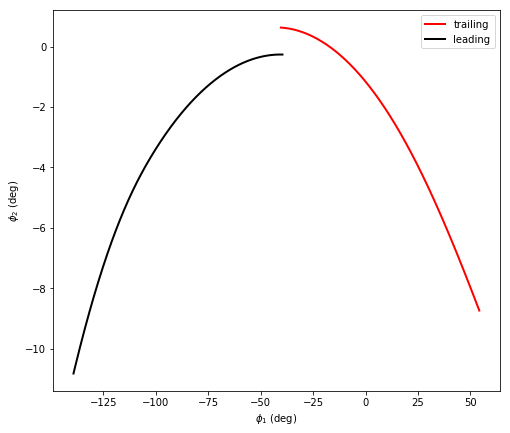

In [9]:
plt.figure(figsize=(8,7))
plt.plot(phi12_trail[:,0],phi12_trail[:,1],lw=2,c='r',label='trailing')
plt.plot(phi12_lead[:,0],phi12_lead[:,1],lw=2,c='k',label='leading')


plt.xlabel(r'$\phi_{1}$ (deg)')
plt.ylabel(r'$\phi_{2}$ (deg)')
#plt.xlim(-70.,70.)
#plt.ylim(-10.,10.)
plt.legend(loc='upper right')
plt.show()

13.518012798378484 23.490600856994885 0.26946667474447417


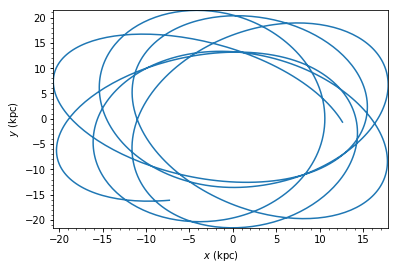

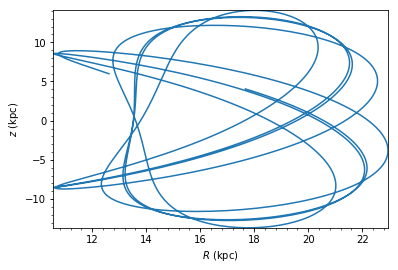

In [10]:
prog_orb=Orbit(gd1_prog_lb,lb=True,ro=8.,vo=220.,solarmotion=[-11.1,24.,7.25])

ts1=np.linspace(0.,-3.4,1000)/bovy_conversion.time_in_Gyr(220.,8.)
prog_orb.integrate(ts1,MWPotential2014)

prog_orb.plot(d1='x',d2='y')
prog_orb.plot(d1='R',d2='z')

print (prog_orb.rperi(),prog_orb.rap(),prog_orb.e())

